Imaging Through Turbulence
==============


This notebook shows examples of using `aotools` to do the following:
- Create a PSF from an aperture function
- Measure the structure of PSFs
- Create aberrated PSFs including turbulence
- Apply PSFs to extended images


In [1]:
import numpy
import matplotlib.pylab as plt
from tqdm import tqdm, trange, tqdm_notebook
from astropy.io import fits
# %matplotlib inline
import aotools
from aotools.turbulence import infinitephasescreen, phasescreen
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.colors as colors

import scipy.signal
j = 0+1j

Like before we need to set the parameters for the scale of our simulation and the strength of atmospheric turbulence we want to simulate.

In [2]:
# Set up parameters for creating phase screens
nx_size = 64 # pxls
D = 1 # m
pxl_scale = 1/64 # m/pxl
pad_factor = 2 
r0 = 0.16 # m 
L0 = 100 # m
l0=1e-3 # m
wavelength = 500e-9 # m

Before looking at aberrated PSFs first we will show the process of creating a simple PSF for a flat incident wavefront. To do this we impose a circular aperture on the phase screen in order to create a more realistic optical system. This can be done by multiplying the screen by the circular function `aotools.circle`.

In [3]:
pupil = aotools.circle(D/pxl_scale/2, nx_size)

This simply creates a mask which we can use to create more realistic simulations of optical systems.

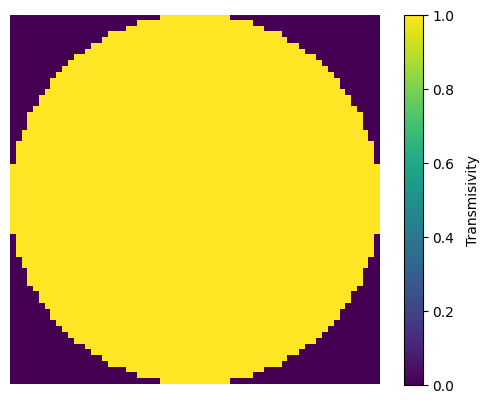

In [4]:
plt.figure()
plt.imshow(pupil)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Transmisivity', labelpad=8)

The most simplistic way of simulating an imaging optical system is to use Fourier Transforms in order to calculate the PSF of the aperture.

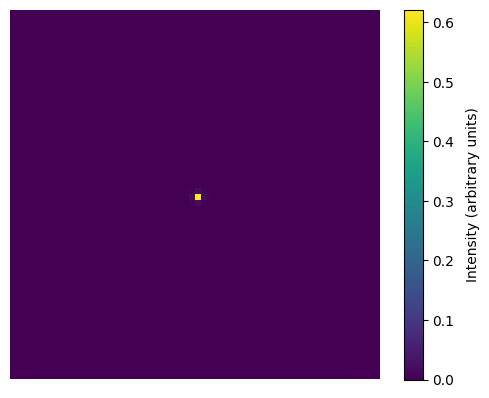

In [5]:
complex_wave = pupil*numpy.exp(j*0)
psf = numpy.abs(aotools.ft2(complex_wave, delta=pxl_scale))**2.

plt.figure()
plt.imshow(psf)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

Note that this PSF does not look particularly well sampled, although the spatial scales are included based on the input parameters. 

The formula for converting between real space pixel scale $\delta_x$ (m) and Fourier domain pixel scale $\delta_f$ (1/m) is (see [this book](https://www.spiedigitallibrary.org/ebooks/PM/Numerical-Simulation-of-Optical-Wave-Propagation-with-Examples-in-MATLAB/eISBN-9780819483270/10.1117/3.866274))

$$ \delta_f = \frac{1}{N \delta_x} $$

where $N$ is the number of pixels. To increase the resolution we therefore pad the pupil plane array with zeros, increasing $N$ and decreasing $\delta_f$.

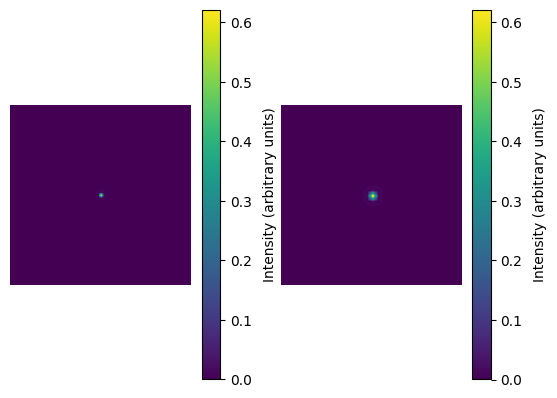

In [8]:
# Create padding to get an oversampled psf at the end to make it look nice
pad_size = nx_size*pad_factor
padded_pupil = numpy.zeros((pad_size, pad_size))
padded_pupil[:nx_size, :nx_size] = pupil

complex_wave = padded_pupil*numpy.exp(j*0)

# Use AOtools to transform from the pupil to the focal plane
E_f = aotools.ft2(complex_wave, delta=pxl_scale,)
psf = numpy.abs(E_f)**2

# Cut out the centre of the psf array for prettier plotting
psf_cut = psf[int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2), int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(psf)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)
plt.subplot(1, 2, 2)
plt.imshow(psf_cut)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

The PSF produced is circularly symmetric, so we can use the `aotools.azimuthal_average` function in order to show the PSF more clearly. Usually we want some physical unit which is useful to us, not simply "pixels". The angular scale of the image plane after a Fourier Transform is given by $\frac{\lambda}{N \delta_x}$ (i.e. $\lambda \delta_f$).

Text(0, 0.5, 'relative intensity')

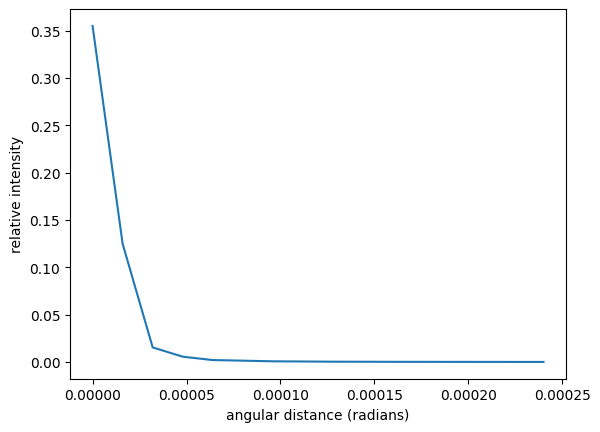

In [11]:
azi_avg = aotools.azimuthal_average(psf)
x_radial = numpy.arange(nx_size//4) * wavelength / (pad_factor * pxl_scale)
plt.figure()
plt.plot(x_radial, azi_avg[:nx_size//4])
plt.xlabel("angular distance (radians)")
plt.ylabel("relative intensity")

Adding Turbulence
-----------------
Now we have these tools we can look at how turbulence affects these PSFs. First we need to create a phase screen. Note we make the phase screen larger than our pupil, the same size as our padded pupil. Creating phase screens larger than the pupil is usually a good idea to ensure good representation of low order modes (e.g. tip/tilt) across the aperture

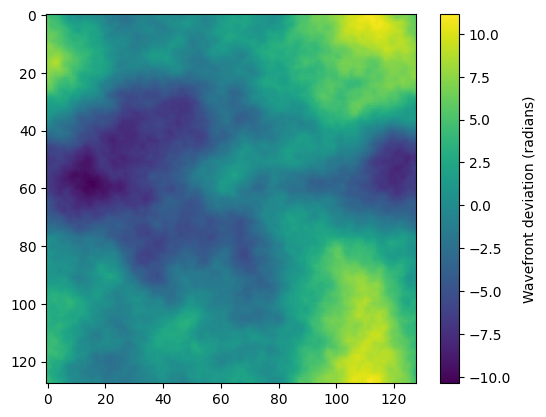

In [12]:
# Create the phase screen object using aotools
phase_screen = phasescreen.ft_phase_screen(r0, nx_size * pad_factor, pxl_scale, L0, l0)

plt.figure()
plt.imshow(phase_screen)
cbar = plt.colorbar()
cbar.set_label("Wavefront deviation (radians)", labelpad=8)

Now we create our electric field in the aperture plane as before, by multiplying by the pupil function and taking the complex exponent of the phase provided by our phase screen. Note that this is now a complex quantity, so we can plot the amplitude with `numpy.abs` or use `numpy.angle` to get the phase, but it will be wrapped between $-\pi$ and $\pi$. Phase unwrapping is a non-trivial problem! 

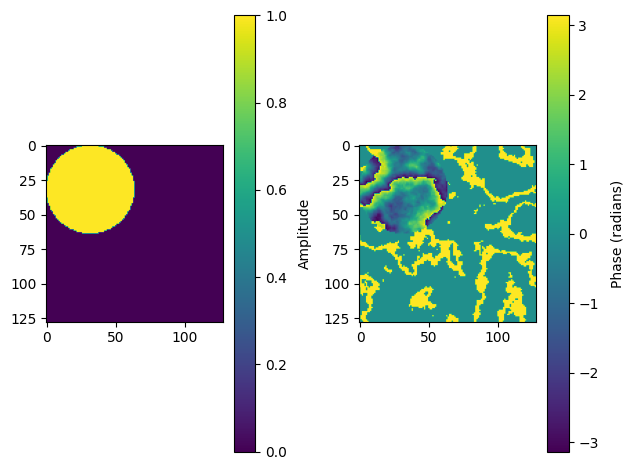

In [13]:
complex_phase = padded_pupil * numpy.exp(j * phase_screen)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(numpy.abs(complex_phase))
cbar = plt.colorbar()
cbar.set_label('Amplitude', labelpad=8)
plt.subplot(1,2,2)
plt.imshow(numpy.angle(complex_phase))
cbar = plt.colorbar()
cbar.set_label('Phase (radians)', labelpad=8)
plt.tight_layout()

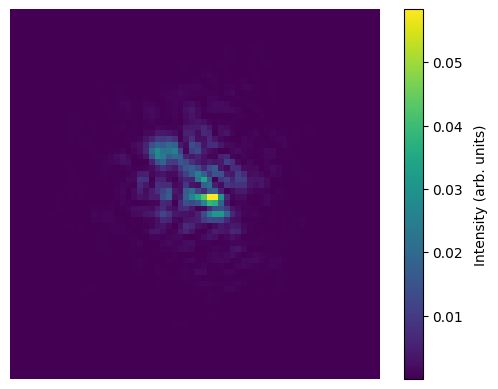

In [14]:
# Use AOtools to transform from the pupil to the focal plane
psf_turb = numpy.abs(aotools.ft2(complex_phase, delta=pxl_scale,))**2

# Cut out the centre of the psf array for prettier plotting
psf_turb_cut = psf_turb[int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2), int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.imshow(psf_turb_cut)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arb. units)', labelpad=8)

This is an instantanious snapshot of the turbulence, so generates and instantanious PSF. This is not the averaged PSF which a traditional "slow" camera would see. In order to generate this from simulation we would need to average many instances of turbulence.

In [15]:
n_scrns = 1000
psfs = numpy.zeros((n_scrns, nx_size*pad_factor, nx_size*pad_factor))

for n in tqdm(range(n_scrns)):
    phase_screen = phasescreen.ft_phase_screen(r0, nx_size*pad_factor, pxl_scale, L0, l0)
    complex_field = padded_pupil * numpy.exp(j*phase_screen)
    psf_tmp = numpy.abs(aotools.ft2(complex_field, delta=pxl_scale))**2.
    psfs[n] = psf_tmp

average_psf = psfs.mean(0)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 798.69it/s]


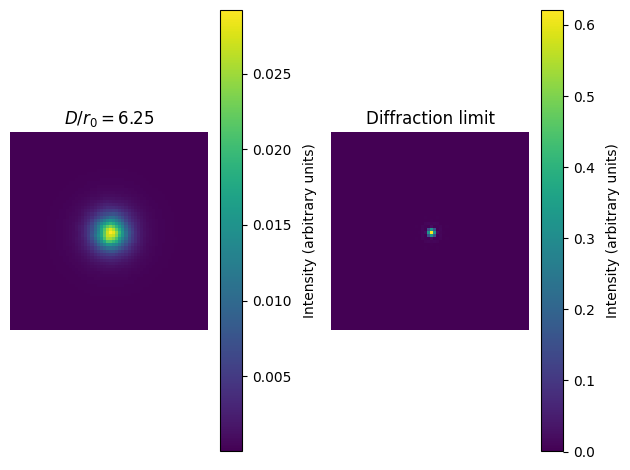

In [16]:
# Cut out the centre of the psf array for prettier plotting
psf_avg_cut = average_psf[int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2), int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.subplot(1,2,1)
plt.imshow(psf_avg_cut)
plt.title(f"$D/r_0={D/r0:.2f}$")
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)
plt.subplot(1,2,2)
plt.imshow(psf_cut)
plt.axis('off')
plt.title("Diffraction limit")
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)
plt.tight_layout()

[]

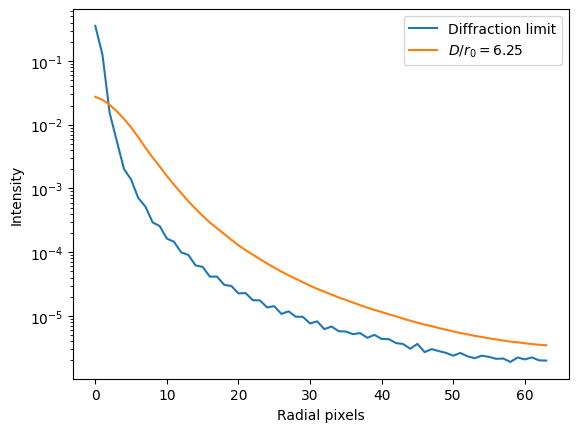

In [17]:
plt.figure()
plt.plot(azi_avg, label='Diffraction limit')
plt.plot(aotools.azimuthal_average(average_psf), label=f"$D/r_0={D/r0:.2f}$")
plt.legend(loc=0)
plt.ylabel("Intensity")
plt.xlabel("Radial pixels")
plt.semilogy()

We can also see how a PSF evolves as a phase screen evolves, similarly to how we saw the phase screen evolve previously.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


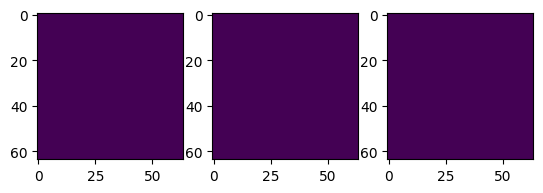

In [18]:
frames=1000

phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0)
padded_pupil = numpy.zeros((nx_size*pad_factor, nx_size*pad_factor), dtype=numpy.complex64)
psfs = numpy.zeros((frames, nx_size*pad_factor, nx_size*pad_factor))

# Video of moving a phase screen and PSF
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3)
screen_image = ax1.imshow(numpy.zeros((nx_size, nx_size)))
psf_image = ax2.imshow(numpy.zeros((nx_size, nx_size)))
average_image = ax3.imshow(numpy.zeros((nx_size, nx_size)))

def init():
    screen_image.set_data(numpy.zeros((nx_size, nx_size)))
    psf_image.set_data(numpy.zeros((nx_size, nx_size)))
    average_image.set_data(numpy.zeros((nx_size, nx_size)))
    return (screen_image, psf_image, average_image,)

def animate(i):  
    phase_screen.add_row()
    wavefront = numpy.copy(phase_screen.scrn)
    screen_image.set_data(wavefront*aotools.circle(nx_size/2, nx_size))
    screen_image.autoscale()
    
    padded_pupil[:nx_size, :nx_size] = pupil * numpy.exp(j*wavefront)
    
    # Use AOtools to transform from the pupil to the focal plane
    psf = numpy.abs(aotools.ft2(padded_pupil, delta=pxl_scale))**2.
    
    psf_cut = psf[int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2), int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2)]
    
    psf_image.set_data(psf_cut)
    psf_image.autoscale()
    
    psfs[i] = numpy.copy(psf)
    average_psf = psfs[:i+1].mean(0)
    average_psf_cut = average_psf[int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2), int(pad_size/2-nx_size/2):int(pad_size/2+nx_size/2)]
    
    average_image.set_data(average_psf_cut)
    average_image.autoscale()
    
    return (screen_image, psf_image, average_image)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=100, 
                               blit=True)

In [19]:
HTML(anim.to_html5_video())

Extended Sources
================

We can apply PSFs we have generated here to extended sources using convolutions. First lets load an image of some solar granulation.

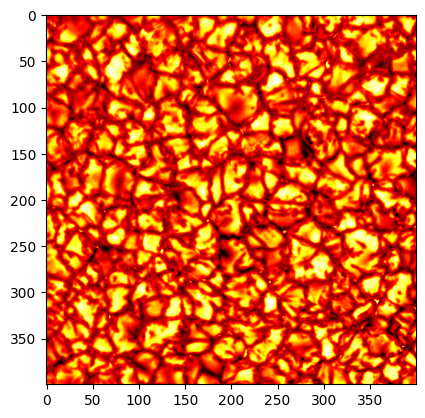

In [20]:
image = fits.getdata("sun_small.fits")[:400, :400]
average_psf = psfs.mean(0)
plt.figure()
plt.imshow(image, cmap='hot')

We can "apply" turbulence to images by convovling them with a PSF. Equally we can apply the diffraction from an aperture, or the effects from telescopes such as the secondary obscuration and spiders.

If applying a PSF to an extended image it is important to make sure the spatial scales of the PSF and the image match.

In [21]:
aberrated_image = scipy.signal.convolve2d(image, average_psf, mode='same')
diffraction_limited_image = scipy.signal.convolve2d(image, psf, mode='same')

Text(0.5, 1.0, '$D/r_0=6.25$')

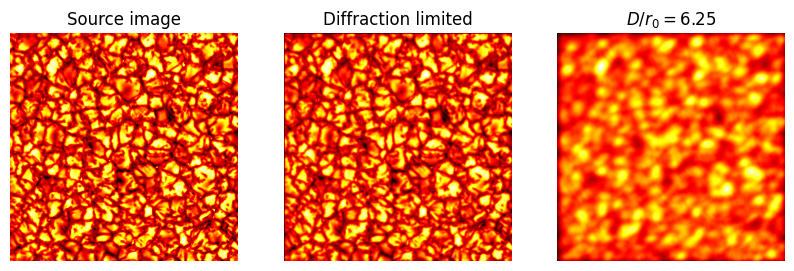

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(image, cmap='hot')
plt.axis('off')
plt.title("Source image")
plt.subplot(1,3,2)
plt.imshow(diffraction_limited_image, cmap='hot')
plt.axis('off')
plt.title("Diffraction limited")
plt.subplot(1,3,3)
plt.imshow(aberrated_image, cmap='hot')
plt.axis('off')
plt.title(f"$D/r_0={D/r0:.2f}$")

There are a few things to note here. Firstly, applying the aberrated PSF has clearly reduced the "resolution" of the image. Secondly, this has led to a reduction in the contrast. Finally, using this simple method to apply a PSF means that the edges have artifacts.